# Import Required Libraries
Import necessary libraries such as pandas, numpy, scipy, and matplotlib.

In [18]:
# Import Required Libraries
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.signal import butter, filtfilt
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from geopy.distance import geodesic

# Load and Display CSV Data
Load the accelerometer, orientation, and location data from CSV files and display the first few rows of each DataFrame.

In [26]:
import pandas as pd


# Charger les fichiers CSV
accel_df = pd.read_csv('accelerometer.csv', sep=',')
orient_df = pd.read_csv('orientation.csv', sep=',')
location_df = pd.read_csv('location.csv', sep=',')

# Afficher les DataFrames chargés
print("Accelerometer DataFrame:")
print(accel_df.head())

print("\nOrientation DataFrame:")
print(orient_df.head())

print("\nLocation DataFrame:")
print(location_df.head())

# Fusionner les données des trois CSV selon le temps
merged_df = pd.merge_asof(accel_df.sort_values('time'), orient_df.sort_values('time'), on='time', direction='nearest')
merged_df = pd.merge_asof(merged_df.sort_values('time'), location_df.sort_values('time'), on='time', direction='nearest')

merged_df.head()


Accelerometer DataFrame:
                  time  seconds_elapsed         z         y         x
0  1728905892151481300         0.124481  3.031113  1.739928 -2.738261
1  1728905892161481200         0.134481  2.543669  2.172559 -2.676702
2  1728905892171481300         0.144481  0.708398  1.350286 -2.833233
3  1728905892181481200         0.154481 -0.942148  0.140309 -2.983238
4  1728905892191481300         0.164481 -2.296083 -0.994283 -3.362856

Orientation DataFrame:
                  time  seconds_elapsed        qz        qy        qx  \
0  1728905892151481300         0.124481  0.405595  0.021519  0.182252   
1  1728905892161481200         0.134481  0.408554  0.012109  0.184250   
2  1728905892171481300         0.144481  0.413500  0.005160  0.188648   
3  1728905892181481200         0.154481  0.419639  0.000997  0.195267   
4  1728905892191481300         0.164481  0.426294 -0.001826  0.204571   

         qw      roll     pitch       yaw  
0  0.895440 -0.116665 -0.351011 -0.871329  
1  0

,time,seconds_elapsed_x,z,y,x,seconds_elapsed_y,qz,qy,qx,qw,...,seconds_elapsed,bearingAccuracy,speedAccuracy,verticalAccuracy,horizontalAccuracy,speed,bearing,altitude,longitude,latitude
0,1728905892151481300,0.124481,3.031113,1.739928,-2.738261,0.124481,0.405595,0.021519,0.182252,0.895440,...,1.439,45.0,1.5,1.099718,17.941,0.0,0.0,74.099998,-0.607808,44.79805
1,1728905892161481200,0.134481,2.543669,2.172559,-2.676702,0.134481,0.408554,0.012109,0.184250,0.893861,...,1.439,45.0,1.5,1.099718,17.941,0.0,0.0,74.099998,-0.607808,44.79805
2,1728905892171481300,0.144481,0.708398,1.350286,-2.833233,0.144481,0.413500,0.005160,0.188648,0.890731,...,1.439,45.0,1.5,1.099718,17.941,0.0,0.0,74.099998,-0.607808,44.79805
3,1728905892181481200,0.154481,-0.942148,0.140309,-2.983238,0.154481,0.419639,0.000997,0.195267,0.886437,...,1.439,45.0,1.5,1.099718,17.941,0.0,0.0,74.099998,-0.607808,44.79805
4,1728905892191481300,0.164481,-2.296083,-0.994283,-3.362856,0.164481,0.426294,-0.001826,0.204571,0.881146,...,1.439,45.0,1.5,1.099718,17.941,0.0,0.0,74.099998,-0.607808,44.79805


# Implement High-Pass Filter
Define a function to implement a high-pass filter using scipy's signal processing functions.

In [27]:
# Implement High-Pass Filter
def high_pass_filter(data, cutoff_frequency, sampling_rate):
    """
    Apply a high-pass filter to the data.
    
    Parameters:
    - data: The input signal data to be filtered.
    - cutoff_frequency: The cutoff frequency of the high-pass filter.
    - sampling_rate: The sampling rate of the data.
    
    Returns:
    - filtered_data: The filtered signal data.
    """
    # Normalize the cutoff frequency with the Nyquist frequency
    nyquist_frequency = 0.5 * sampling_rate
    normalized_cutoff = cutoff_frequency / nyquist_frequency
    
    # Design the high-pass filter
    b, a = butter(N=1, Wn=normalized_cutoff, btype='high', analog=False)
    
    # Apply the filter to the data
    filtered_data = filtfilt(b, a, data)
    
    return filtered_data

# Apply the high-pass filter to the Z-axis acceleration data
sampling_rate = 100  # Example sampling rate in Hz, adjust as needed
cutoff_frequency = 0.1  # Example cutoff frequency in Hz, adjust as needed

merged_df['filtered_z'] = high_pass_filter(merged_df['z'], cutoff_frequency, sampling_rate)

# Display the first few rows of the DataFrame with the filtered data
merged_df.head()



def get_color_from_shock(z_value, min_z, max_z):
    norm = mcolors.Normalize(vmin=min_z, vmax=max_z)
    cmap = plt.get_cmap('RdYlGn_r')  # Gradient de rouge à vert inversé
    rgba = cmap(norm(z_value))
    return mcolors.to_hex(rgba)

# Detect Shocks with Filtered Data
Use the filtered accelerometer data to detect shocks based on a specified threshold.

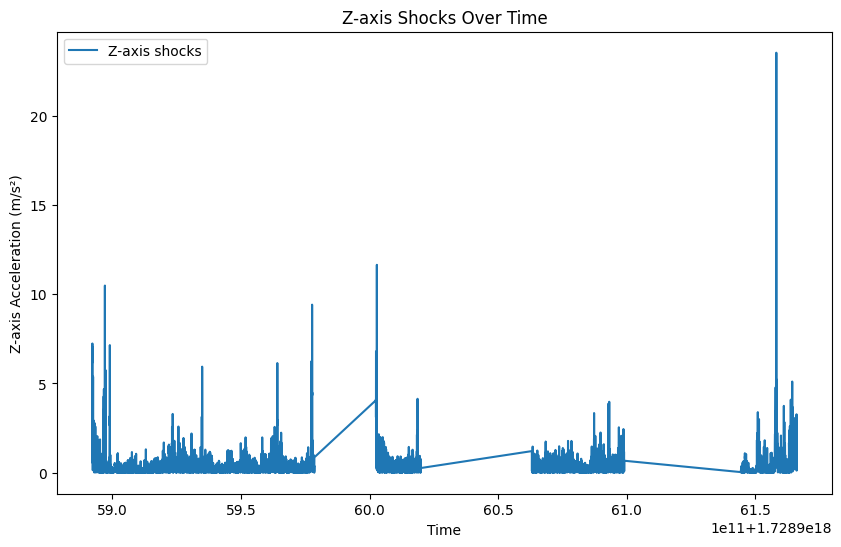

In [28]:
# Detect Shocks with Filtered Data

# Function to convert quaternions to rotation matrix
def quaternion_to_rotation_matrix(qw, qx, qy, qz):
    return R.from_quat([qx, qy, qz, qw])

# Apply the rotation to get acceleration in the global frame
def rotate_acceleration(accel_x, accel_y, accel_z, rotation):
    accel_local = np.array([accel_x, accel_y, accel_z])
    accel_global = rotation.apply(accel_local)
    return accel_global

# List to store results
results = []

# Parameter to detect vertical shocks (only on the Z-axis)
shock_threshold = 3  # adjustable shock detection threshold

# Lists to store times and Z-axis shocks
times = []
z_shocks = []

# Iterate through each row in the merged DataFrame
for _, row in merged_df.iterrows():
    # Retrieve acceleration and orientation values
    accel_z = row['filtered_z']  # Use filtered Z-axis acceleration
    qw, qx, qy, qz = row['qw'], row['qx'], row['qy'], row['qz']
    
    # Get the rotation matrix from quaternions
    rotation = quaternion_to_rotation_matrix(qw, qx, qy, qz)
    
    # Apply the rotation to the Z-axis acceleration
    accel_global = rotate_acceleration(0, 0, accel_z, rotation)
    
    # Get the Z component in the global frame
    z_global = accel_global[2]
    
    # Add the value to the times and shocks lists
    times.append(row['time'])
    z_shocks.append(abs(z_global))
    
    # Detect a shock if the Z component exceeds the threshold
    if abs(z_global) > shock_threshold:
        results.append((row['time'], abs(z_global), row['latitude'], row['longitude']))

# If shocks are detected, display them on a map
m = folium.Map(location=[location_df['latitude'].iloc[0], location_df['longitude'].iloc[0]], zoom_start=15)

# Draw the trajectory on the map with a line
trajectory = list(zip(location_df['latitude'], location_df['longitude']))
folium.PolyLine(trajectory, color='blue', weight=2.5, opacity=0.7).add_to(m)

# Filter shocks to avoid redundancy (keep only one shock per 1 meter zone)
def distance_between_coords(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

if results:
    shock_df = pd.DataFrame(results, columns=['time', 'z_global', 'latitude', 'longitude'])
    
    # Find the min and max shock values to normalize colors
    min_z = shock_df['z_global'].min()
    max_z = shock_df['z_global'].max()

    filtered_shocks = []  # List to store non-redundant shocks

    # Iterate through detected shocks and filter those too close
    for i, row in shock_df.iterrows():
        lat, lon, z_global = row['latitude'], row['longitude'], row['z_global']
        
        too_close = False
        for j, shock in enumerate(filtered_shocks):
            lat2, lon2, z_global2 = shock[2], shock[3], shock[1]
            if distance_between_coords(lat, lon, lat2, lon2) < 1:
                too_close = True
                # If a shock is already close, keep the one with the greatest intensity
                if z_global > z_global2:
                    filtered_shocks[j] = (row['time'], z_global, lat, lon)
                break
        
        if not too_close:
            filtered_shocks.append((row['time'], z_global, lat, lon))

    # Add filtered shock points to the map with a color gradient
    for shock in filtered_shocks:
        time, z_global, lat, lon = shock
        shock_color = get_color_from_shock(z_global, min_z, max_z)
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            popup=f"Shock detected at {time} with an acceleration of {z_global:.2f} m/s²",
            color=shock_color,
            fill=True,
            fill_opacity=0.7
        ).add_to(m)

# Display the Z-axis shocks over time
plt.figure(figsize=(10, 6))
plt.plot(times, z_shocks, label='Z-axis shocks')
plt.xlabel('Time')
plt.ylabel('Z-axis Acceleration (m/s²)')
plt.title('Z-axis Shocks Over Time')
plt.legend()
plt.show()

# Display the map
m

Taux d'échantillonnage calculé : 100.00 Hz
Seuil dynamique basé sur le 85.0ème percentile : 0.43 m/s²


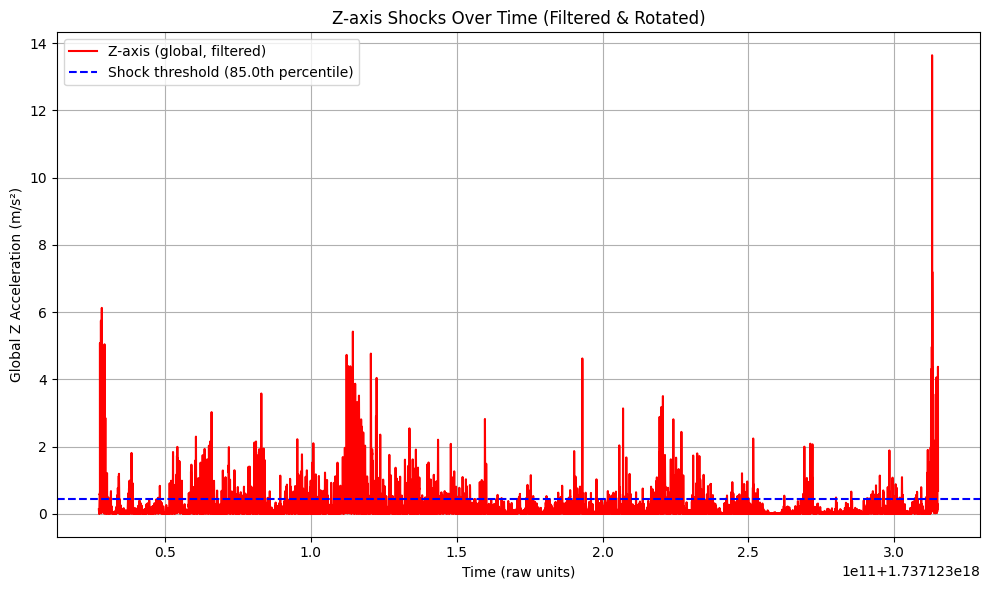

In [11]:
# --------------------------------------------------------------------------------
# 1) Imports et Configuration
# --------------------------------------------------------------------------------

import pandas as pd
import numpy as np
import json
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from geopy.distance import geodesic
from scipy.signal import butter, filtfilt, find_peaks
from scipy.spatial.transform import Rotation as R
from branca.element import MacroElement
from jinja2 import Template

# --------------------------------------------------------------------------------
# Paramètres Configurables
# --------------------------------------------------------------------------------

# Fichier JSON
JSON_FILE_PATH = 'sensor_data_3.json'  # Mettre à jour le chemin si nécessaire

# Paramètres du filtre passe-haut
DEFAULT_SAMPLING_RATE = 100     # Hz, sera remplacé par un calcul dynamique
DEFAULT_CUTOFF_FREQUENCY = 0.5  # Hz
DEFAULT_FILTER_ORDER = 2

# Paramètres de détection des chocs
SHOCK_THRESHOLD_METHOD = 'percentile'  # 'percentile' ou 'mean_std'
SHOCK_THRESHOLD_PARAM = 85.0           # Percentile ou nombre d'écarts-types
DEFAULT_SPEED_THRESHOLD = 5.0          # m/s

# Paramètres de la carte Folium
COLOR_MAP = 'RdYlGn_r'  # Colormap pour les chocs (rouge -> vert inversé)

# --------------------------------------------------------------------------------
# 2) Lecture du fichier JSON et création des DataFrames
# --------------------------------------------------------------------------------

with open(JSON_FILE_PATH, 'r') as file:
    data = json.load(file)

# Convert to main DataFrame
df = pd.DataFrame(data)

# Créer des DataFrames pour chaque capteur
accel_df = df[df['sensor'] == 'Accelerometer'][['time', 'x', 'y', 'z']]
orient_df = df[df['sensor'] == 'Orientation'][['time', 'qx', 'qy', 'qz', 'qw']]
location_df = df[df['sensor'] == 'Location'][['time', 'longitude', 'latitude', 'altitude', 'speed']]

# Convertir les colonnes en float
for sub_df in [accel_df, orient_df, location_df]:
    # Convertir time en numérique
    sub_df[['time']] = sub_df[['time']].apply(pd.to_numeric, errors='coerce')
    
    # Convertir les autres colonnes (x,y,z,qx,qy,qz, etc.) en float
    numeric_cols = [col for col in sub_df.columns if col != 'time']
    sub_df[numeric_cols] = sub_df[numeric_cols].astype(float, errors='ignore')

# Nettoyer les éventuelles lignes NaN
accel_df.dropna(inplace=True)
orient_df.dropna(inplace=True)
location_df.dropna(inplace=True)

# --------------------------------------------------------------------------------
# 3) Fusion sur la base du temps (nearest)
# --------------------------------------------------------------------------------

accel_df.sort_values('time', inplace=True)
orient_df.sort_values('time', inplace=True)
location_df.sort_values('time', inplace=True)

merged_df = pd.merge_asof(
    accel_df,
    orient_df,
    on='time',
    direction='nearest'
)

merged_df = pd.merge_asof(
    merged_df.sort_values('time'),
    location_df.sort_values('time'),
    on='time',
    direction='nearest'
)

# On retire les lignes qui manqueraient de colonnes essentielles
merged_df.dropna(subset=['x', 'z', 'qx', 'qw', 'latitude', 'longitude'], inplace=True)

# --------------------------------------------------------------------------------
# 4) Filtre passe-haut (ordre 2) pour l'accélération Z avec paramètres dynamiques
# --------------------------------------------------------------------------------

def calculate_sampling_rate(time_series):
    """
    Calcule le taux d'échantillonnage à partir de la série temporelle.
    
    :param time_series: Pandas Series contenant les timestamps en nanosecondes
    :return: Taux d'échantillonnage en Hz
    """
    # Calculer les différences de temps en secondes
    time_diffs = time_series.diff().dropna() / 1e9  # Convertir nanosecondes en secondes
    median_diff = time_diffs.median()
    sampling_rate = 1 / median_diff if median_diff > 0 else DEFAULT_SAMPLING_RATE  # Fallback à 100 Hz si erreur
    return sampling_rate

# Convertir 'time' en numérique si ce n'est pas déjà fait
merged_df['time'] = pd.to_numeric(merged_df['time'], errors='coerce')

# Calculer le taux d'échantillonnage
sampling_rate = calculate_sampling_rate(merged_df['time'])
print(f"Taux d'échantillonnage calculé : {sampling_rate:.2f} Hz")

def high_pass_filter(data, cutoff_frequency, sampling_rate, order=2):
    """
    Applique un filtre passe-haut Butterworth d'ordre `order`.
    
    :param data: array-like, signal à filtrer
    :param cutoff_frequency: fréquence de coupure (Hz)
    :param sampling_rate: fréquence d'échantillonnage (Hz)
    :param order: ordre du filtre Butterworth
    :return: signal filtré
    """
    nyquist_frequency = 0.5 * sampling_rate
    normalized_cutoff = cutoff_frequency / nyquist_frequency
    
    b, a = butter(N=order, Wn=normalized_cutoff, btype='high', analog=False)
    try:
        filtered_data = filtfilt(b, a, data)
    except ValueError as e:
        print(f"Erreur lors de l'application du filtre : {e}")
        # Retourner les données non filtrées si une erreur survient
        filtered_data = data
    return filtered_data

# Paramètres du filtre
cutoff_frequency = DEFAULT_CUTOFF_FREQUENCY  # Hz
filter_order = DEFAULT_FILTER_ORDER

merged_df['filtered_z'] = high_pass_filter(
    merged_df['z'], cutoff_frequency, sampling_rate, order=filter_order
)

# --------------------------------------------------------------------------------
# 5) Détection de chocs sur l'axe Z (global) avec seuil dynamique
# --------------------------------------------------------------------------------

def quaternion_to_rotation_matrix(qw, qx, qy, qz):
    """
    Convertit un quaternion en matrice de rotation.
    scipy attend [x, y, z, w]
    """
    return R.from_quat([qx, qy, qz, qw])

def rotate_acceleration(accel_x, accel_y, accel_z, rotation):
    """
    Applique la rotation à l'accélération locale pour obtenir l'accélération globale.
    """
    accel_local = np.array([accel_x, accel_y, accel_z])
    return rotation.apply(accel_local)

# Collecter toutes les valeurs z_global pour calculer le seuil dynamique
z_globals = []
for _, row in merged_df.iterrows():
    accel_z = row['filtered_z']
    qw, qx, qy, qz = row['qw'], row['qx'], row['qy'], row['qz']
    
    # Calcul de la rotation
    rotation = quaternion_to_rotation_matrix(qw, qx, qy, qz)
    
    # Appliquer la rotation à (0, 0, accel_z) pour récupérer la composante Z globale
    accel_global = rotate_acceleration(0, 0, accel_z, rotation)
    z_global = accel_global[2]
    
    z_globals.append(abs(z_global))

# Fonction pour calculer le seuil dynamique
def calculate_dynamic_threshold(z_values, method='percentile', param=85.0):
    """
    Calcule un seuil dynamique basé sur une méthode spécifiée.
    
    :param z_values: Liste ou array des valeurs d'accélération Z globales
    :param method: Méthode de calcul ('percentile' ou 'mean_std')
    :param param: Paramètre associé à la méthode (percentile ou nombre d'écarts-types)
    :return: Seuil dynamique
    """
    if method == 'percentile':
        threshold = np.percentile(z_values, param)
        print(f"Seuil dynamique basé sur le {param}ème percentile : {threshold:.2f} m/s²")
    elif method == 'mean_std':
        mean_z = np.mean(z_values)
        std_z = np.std(z_values)
        threshold = mean_z + param * std_z
        print(f"Seuil dynamique basé sur la moyenne + {param} * écart-type : {threshold:.2f} m/s²")
    else:
        raise ValueError(f"Méthode de seuil inconnue : {method}")
    return threshold

# Calculer le seuil dynamique
shock_threshold = calculate_dynamic_threshold(z_globals, method=SHOCK_THRESHOLD_METHOD, param=SHOCK_THRESHOLD_PARAM)

# Détection des chocs en utilisant le seuil dynamique
speed_threshold = DEFAULT_SPEED_THRESHOLD  # m/s

times = []
z_shocks = []
results = []  # liste (time, z_global, lat, lon)

for _, row in merged_df.iterrows():
    accel_z = row['filtered_z']
    qw, qx, qy, qz = row['qw'], row['qx'], row['qy'], row['qz']
    speed = row['speed']
    
    # Calcul de la rotation
    rotation = quaternion_to_rotation_matrix(qw, qx, qy, qz)
    
    # Appliquer la rotation pour obtenir la composante Z globale
    accel_global = rotate_acceleration(0, 0, accel_z, rotation)
    z_global = accel_global[2]
    
    times.append(row['time'])
    z_shocks.append(abs(z_global))
    
    if abs(z_global) > shock_threshold and speed > speed_threshold:
        results.append((row['time'], abs(z_global), row['latitude'], row['longitude']))

# --------------------------------------------------------------------------------
# 6) Carte Folium : affichage de la trajectoire + chocs avec teintes de couleur
# --------------------------------------------------------------------------------

# Création de la carte
if not location_df.empty:
    start_lat = location_df.iloc[0]['latitude']
    start_lon = location_df.iloc[0]['longitude']
else:
    # Fallback si location_df est vide
    start_lat, start_lon = 0.0, 0.0

m = folium.Map(location=[start_lat, start_lon], zoom_start=15)

# Tracer la trajectoire (même s'il n'y a pas de chocs)
if len(location_df) >= 2:
    trajectory = list(zip(location_df['latitude'], location_df['longitude']))
    folium.PolyLine(
        trajectory,
        color='blue',
        weight=2.5,
        opacity=0.7
    ).add_to(m)
elif len(location_df) == 1:
    folium.Marker(
        location=[start_lat, start_lon],
        popup="Single location point",
        icon=folium.Icon(color='blue')
    ).add_to(m)

# Filtrage des chocs (élimination de ceux trop proches < 1 m)
def distance_between_coords(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

filtered_shocks = []
if results:
    shock_df = pd.DataFrame(results, columns=['time', 'z_global', 'latitude', 'longitude'])
    min_z = shock_df['z_global'].min()
    max_z = shock_df['z_global'].max()
    
    for i, row_ in shock_df.iterrows():
        lat, lon, z_g = row_['latitude'], row_['longitude'], row_['z_global']
        too_close = False
        for j, shock in enumerate(filtered_shocks):
            _, z_old, lat_old, lon_old = shock
            if distance_between_coords(lat, lon, lat_old, lon_old) < 1:
                too_close = True
                # On garde celui qui a la plus grande intensité
                if z_g > z_old:
                    filtered_shocks[j] = (row_['time'], z_g, lat, lon)
                break
        if not too_close:
            filtered_shocks.append((row_['time'], z_g, lat, lon))

    def get_color_from_shock(z_value, z_min, z_max, cmap_name='RdYlGn_r'):
        norm = mcolors.Normalize(vmin=z_min, vmax=z_max)
        cmap = plt.get_cmap(cmap_name)
        rgba = cmap(norm(z_value))
        return mcolors.to_hex(rgba)

    # Ajout des chocs filtrés sur la carte
    for shock in filtered_shocks:
        t_, z_g, lat_, lon_ = shock
        color_ = get_color_from_shock(z_g, min_z, max_z, COLOR_MAP)
        folium.CircleMarker(
            location=[lat_, lon_],
            radius=5,
            popup=f"Shock at time={t_}, accel={z_g:.2f} m/s²",
            color=color_,
            fill=True,
            fill_opacity=0.7
        ).add_to(m)

    # Ajout d'une légende de couleur
    class Legend(MacroElement):
        def __init__(self, z_min, z_max, cmap_name='RdYlGn_r'):
            super().__init__()
            self._name = 'Legend'
            template = """
            {% macro html(this, kwargs) %}
            <div style="
                position: fixed;
                bottom: 50px;
                left: 50px;
                width: 150px;
                height: 90px;
                background-color: white;
                border:2px solid grey;
                z-index:9999;
                font-size:14px;
                ">
                &nbsp;<b>Intensité du Choc</b><br>
                &nbsp;<i style="background: {{color_min}}; width: 18px; height: 18px; display: inline-block;"></i>&nbsp;{{min_z}}<br>
                &nbsp;<i style="background: {{color_max}}; width: 18px; height: 18px; display: inline-block;"></i>&nbsp;{{max_z}}
            </div>
            {% endmacro %}
            """
            self._template = Template(template)
            self.z_min = z_min
            self.z_max = z_max
            self.cmap = plt.get_cmap(cmap_name)
            # Normaliser les valeurs pour la colormap
            if z_max > z_min:
                norm = mcolors.Normalize(vmin=z_min, vmax=z_max)
                self.color_min = mcolors.to_hex(self.cmap(norm(z_min)))
                self.color_max = mcolors.to_hex(self.cmap(norm(z_max)))
            else:
                # Si z_min == z_max, attribuer une couleur neutre
                self.color_min = mcolors.to_hex(self.cmap(0.5))
                self.color_max = mcolors.to_hex(self.cmap(0.5))
        
        def render(self, **kwargs):
            self._template.module.color_min = self.color_min
            self._template.module.color_max = self.color_max
            self._template.module.min_z = f"{self.z_min:.2f} m/s²"
            self._template.module.max_z = f"{self.z_max:.2f} m/s²"
            super().render(**kwargs)

    # Ajout de la légende
    m.get_root().add_child(Legend(min_z, max_z, COLOR_MAP))
else:
    print("Aucun choc détecté (selon le seuil dynamique).")

# --------------------------------------------------------------------------------
# 7) Graphique Matplotlib : accélération Z (globale) au cours du temps
# --------------------------------------------------------------------------------

plt.figure(figsize=(10, 6))
plt.plot(times, z_shocks, label='Z-axis (global, filtered)', color='red')
plt.axhline(shock_threshold, color='blue', linestyle='--', label=f'Shock threshold ({SHOCK_THRESHOLD_PARAM}th percentile)')
plt.xlabel('Time (raw units)')
plt.ylabel('Global Z Acceleration (m/s²)')
plt.title('Z-axis Shocks Over Time (Filtered & Rotated)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Afficher la carte dans le notebook 
# (ou m.save('my_map.html') si tu veux sauvegarder en HTML)
m
